In [2]:
# default_exp background_distributions

# Calculating Background Distributions
In order to differentially assess changes of ions/peptides/proteins between conditions, assumptions about the underlying distributions have to be made. This is necessary to distinguish systematic regulation between conditons from random noise. As introduced in the [MS-EmpiRe paper](https://doi.org/10.1074/mcp.RA119.001509) and refined in the [EmpiReS paper](https://doi.org/10.1101/2020.08.23.234237 ), replicate measurements can be utilized to estimate the empirical *background distributions*, which should reflect the noise underlying the measurements. This approach can then be utilized to:
* estimate the background distribtuions in each condition
* estimate the background in condition1 - condition2 (i.e. the distribution of fold changes between conditions)
* the previous two approaches suffice to perform differential quantification. The approach can however also be used for more complex scenarios. For example, if we want to compare, if two peptides change differently from each other, between two conditions, we can also estimate the underlying background (condition1-condition2)_peptide1 - (condition1-condition2)_peptide2

## Capturing the background of an experimental condition

In the context of AlphaQuant, where proteomics measurements are analysed, we use the word *condition* to describe a set of measurments that was acquired to capture a certain biological state (eg. condition "native" as opposed to conditon "heat shock"). We try to characterize conditions by sorting their ions by mean intensity (intensity is a good predictor for variation, as described in the [MS-EmpiRe paper](https://doi.org/10.1074/mcp.RA119.001509)) and then creating a set of background distributions over the whole intensity range. As a result, we can assign a background distribution to each ion as well as each *differential ion* (i.e. the expected variation in the fold changes of this ion).


In [2]:
#hide
import alphaquant.diffquant.background_distributions as aqbg

aqbg.ConditionBackgrounds


alphaquant.diffquant.background_distributions.ConditionBackgrounds

## Estimate the Background Distribution for a given set of quantified ions
The BackGroundDistribution object is created for a subset of ions. The sets of ions are chosen such that we can assume a certain similarity in how they are distributed (see also notes to the ConditionBackground below). The essential information the BackGroundDistribution object receives is a list of ions with their measured intensity values. The background distribution is constructed from these values in two steps:

1. For each ion, randomly select one of the intensities and subtract if from the other intensites. This rescales the values to fold change values.
2. Subsequently, compare the differences in the rescaled values between different ions. This gives an estimate of the variation of the whole distribution.

We  directly derive some basic properties of the distribution and transform it into a 2d representation (binned fc value vs. counts) for memory efficiency. We also transform the distribution into a cumulative one and subsequently transform this distribution into a z-value distribution for quick lookups

In [3]:
#hide

aqbg.BackGroundDistribution


alphaquant.diffquant.background_distributions.BackGroundDistribution

In [5]:
#hide
from numba import jit
from time import time

aqbg.SubtractedBackgrounds


alphaquant.diffquant.background_distributions.SubtractedBackgrounds

## Utility functions for Background calculation

In [6]:
#hide
aqbg.get_subtracted_bg



<function alphaquant.diffquant.background_distributions.get_subtracted_bg(bgpair2diffDist, bg1, bg2, p2z)>

## Unit Tests

In [8]:
import uuid
import pandas as pd
import numpy as np
def generate_random_input(num_pep,sample2cond_df ):
    pepnames = list(map(lambda _idx : str(uuid.uuid4()), range(num_pep))) #gives uuid strings for each peptide
    randarrays = 10+ 1.5*np.random.randn(num_pep,sample2cond_df.shape[0])
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(0, "peptides", pepnames )
    df_intens = df_intens.set_index("peptides")
    return df_intens

sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3'], 'condition' : ['A', 'A', 'A', 'B', 'B', 'B']})
fixed_input = generate_random_input(1000, sample2cond_df)

In [10]:
#hide


def test_condition_backgrounds(unnormed_df):
    condbg = aqbg.ConditionBackgrounds(unnormed_df, {})
    nonbg_ions = list(set(condbg.ion2nonNanvals.keys()).difference(condbg.ion2background.keys()))
    display(condbg.normed_condition_df)
    
    assert condbg.ion2background.keys() == condbg.ion2nonNanvals.keys()


test_condition_backgrounds(fixed_input)


t_ion2nonan_sw 0.002804994583129883
t_intensity_selection 0.07848095893859863


,A1,A2,A3,B1,B2,B3
peptides,,,,,,
23e18edc-5dd1-4ca0-b19f-b5839ba142bf,10.561112,6.237216,7.324758,10.908210,7.106339,8.859802
5724453b-0705-4d2e-a2dc-fea4e0b42409,7.593485,10.592333,6.677844,10.823161,7.821828,8.428079
1767350b-f292-4d1d-bef7-54f96dacce9b,11.960467,9.698599,7.832656,7.093703,7.436212,8.702345
1929813f-d949-4881-b6b8-0374740ec664,9.854877,8.481756,8.093604,7.331206,7.268282,9.585128
9f664b5b-6113-4522-be57-74250885ff2e,10.816099,7.566755,8.728947,9.795063,7.894794,6.997274
...,...,...,...,...,...,...
06c8b180-7cca-46f1-b7bb-7e5b30d83028,11.764066,12.510350,13.280409,6.524015,11.524662,9.159514
ca0c9e0c-1cbd-4ae2-857c-bbef34942cc5,11.465145,12.221560,10.654489,13.427721,7.388200,11.845227
b62165c0-a27f-43d5-a1c8-64fadb995a8d,9.981527,11.985018,12.394870,12.013487,11.936284,10.724222


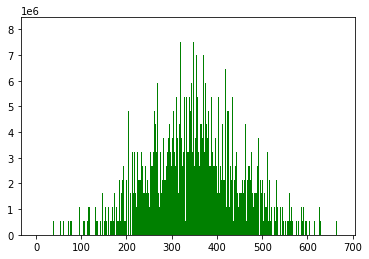

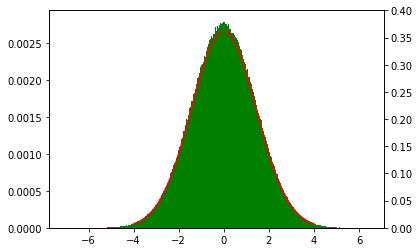

In [11]:
#hide
#test subtract background distribution
from scipy.stats import norm
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import numpy as np

idx2nonnanvals = {}

for idx in range(2000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist1 = aqbg.BackGroundDistribution(0, 999, idx2nonnanvals, idx2ion= dict(zip(idx2nonnanvals.keys(), idx2nonnanvals.keys())),p2z={})
bgdist2 = aqbg.BackGroundDistribution(1000, 1999, idx2nonnanvals,idx2ion= dict(zip(idx2nonnanvals.keys(), idx2nonnanvals.keys())), p2z={})

freqdist = aqbg.get_normed_freqs(bgdist1.cumulative)
plt.bar(range(len(freqdist)),freqdist,width=1,color='g')
plt.show()

subtracted_bgs = aqbg.SubtractedBackgrounds(bgdist1, bgdist2, {})

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales


fc2counts_rescaled = tranform_fc2count_to_fc_space(subtracted_bgs.fc2counts, subtracted_bgs.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g')
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, subtracted_bgs.SD)*1.3, color = "red")
axes2.set_ylim(0.0, 0.4)
plt.show()

